In [1]:
#To do this:
#A virtual environment was set up to deal with dsi-deep-learning-environment

In [2]:
#########################################################################
# Convolutional Neural Network - Fruit Classification
#########################################################################
import os

# Set the working directory
os.chdir(r'C:\Users\19144\OneDrive\Desktop\Data Science Infinity\Deep Learning\CNN')


#########################################################################
# Import required packages
#########################################################################
!pip install h5py
!pip install keras-tuner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import Callback
from keras_tuner.engine.hyperparameters import HyperParameters
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



In [3]:
#Set up flow for training and validation data

#data flow parameters

training_data_dir = 'data/training'
validation_data_dir = 'data/validation'
batch_size = 32
img_width = 128
img_height = 128
num_channels = 3
num_classes = 6

#image generations

training_generator = ImageDataGenerator(rescale = 1./255, #Add in transformation logic...we only do this for training data***...this is a bit of trial and error
                                        rotation_range=20, #Between -20 and 20 degree rotation will be randomly selected
                                        width_shift_range = 0.2, #Shift up to 20% of width
                                        height_shift_range = 0.2, #Shift up to 20% of height
                                        zoom_range = 0.1,
                                        horizontal_flip = True,
                                        brightness_range = (0.5,1.5),
                                        fill_mode = 'nearest') #Nearest pixel will be used to fill in any new pixels that are required
#Subtle changes are good to start with here

validation_generator = ImageDataGenerator(rescale = 1./255)

#image flows 

training_set = training_generator.flow_from_directory(directory=training_data_dir,
                                                      target_size=(img_width, img_height),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')

validation_set = validation_generator.flow_from_directory(directory = validation_data_dir, #training data
                                                        target_size = (img_width, img_height),#Size of images
                                                        batch_size = batch_size,#Amount of images passed for each mini-batch
                                                        class_mode = "categorical")#What type of problem is being solved - multi-class classification problem her


Found 360 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [4]:
#########################################################################
# Architecture Tuning
#########################################################################
#network architecture
def build_model(hp): #hyper parameter tuning is here 
    model = Sequential()

    model.add(Conv2D(filters = hp.Int("Input_Conv_Filters", min_value = 32, max_value = 128, step = 32), kernel_size=(3,3), padding = "same", input_shape = (img_width, img_height, num_channels))) #hpInt - we want an integer
    #This will test 32, 64, 96, 128 filters
    model.add(Activation("relu"))
    model.add(MaxPooling2D()) 
    
    for i in range(hp.Int("n_Conv_Filters", min_value = 1, max_value = 3, step = 1)): #Testing either 1 or 2 convolutional layers here against the randomized filters above

        model.add(Conv2D(filters = hp.Int(f"Conv_{i}_Filters", min_value = 32, max_value = 128, step = 32), kernel_size=(3,3), padding = "same")) 
        model.add(Activation("relu"))
        model.add(MaxPooling2D()) 

    #Flattening
    model.add(Flatten())

    for j in range(hp.Int("n_Dense_Layers", min_value = 1, max_value = 4, step = 1)): #separate loop, change i to j
       
        model.add(Dense(hp.Int(f"Dense_{j}_Neurons", min_value = 32, max_value = 128, step = 32)))
        model.add(Activation("relu"))
        
        if hp.Boolean("Dropout"): #True values drop out, false it will not drop out
            model.add(Dropout(0.5))

    model.add(Dense(num_classes)) #Forced to have specific number of neurons...this is output...neuron for each of the classes we want to predict...we have 6 classes (see above) use num_classes
    model.add(Activation("softmax")) #Need 6 probabilities for each image - this will take all output vales and ensure they add up to 1 or 100%

    # compile network

    model.compile(loss = "categorical_crossentropy",
                  optimizer = hp.Choice("Optimizer", values = ['adam', 'RMSProp']),
                  metrics = ["accuracy"])      
    
    return model

In [5]:
tuner = RandomSearch(hypermodel = build_model, #name of function of architecture
                    objective = 'val_accuracy', #what we want tuner to optimize
                    max_trials = 3, #we need to limit amount of random combinations based on architecture we set up above
                    executions_per_trial = 2, #each trial will be run 2x
                    directory = os.path.normpath('C:/'),#new folder in directory
                    project_name = 'fruit-cnn',
                    overwrite = True) #name of folder

In [6]:
tuner.search(x = training_set,
            validation_data = validation_set,
            epochs = 5,
            batch_size = 32)
best_model = tuner.get_best_models()[0]

Trial 3 Complete [00h 01m 26s]
val_accuracy: 0.32777777314186096

Best val_accuracy So Far: 0.43611110746860504
Total elapsed time: 00h 03m 21s
INFO:tensorflow:Oracle triggered exit


In [7]:
#top networks
tuner.results_summary()
#This shows best trial first here...0.436

Results summary
Results in C:\fruit-cnn
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
Input_Conv_Filters: 64
n_Conv_Filters: 2
Conv_0_Filters: 64
n_Dense_Layers: 4
Dense_0_Neurons: 64
Dropout: False
Optimizer: adam
Conv_1_Filters: 32
Dense_1_Neurons: 32
Dense_2_Neurons: 32
Dense_3_Neurons: 32
Score: 0.43611110746860504
Trial summary
Hyperparameters:
Input_Conv_Filters: 32
n_Conv_Filters: 3
Conv_0_Filters: 96
n_Dense_Layers: 4
Dense_0_Neurons: 32
Dropout: False
Optimizer: RMSProp
Conv_1_Filters: 32
Dense_1_Neurons: 32
Dense_2_Neurons: 128
Dense_3_Neurons: 64
Conv_2_Filters: 32
Score: 0.32777777314186096
Trial summary
Hyperparameters:
Input_Conv_Filters: 96
n_Conv_Filters: 3
Conv_0_Filters: 64
n_Dense_Layers: 3
Dense_0_Neurons: 64
Dropout: False
Optimizer: adam
Conv_1_Filters: 96
Dense_1_Neurons: 64
Dense_2_Neurons: 64
Dense_3_Neurons: 64
Conv_2_Filters: 128
Score: 0.32777777314186096


In [8]:
#Best network - hyperparameters
tuner.get_best_hyperparameters()[0].values

{'Input_Conv_Filters': 64,
 'n_Conv_Filters': 2,
 'Conv_0_Filters': 64,
 'n_Dense_Layers': 4,
 'Dense_0_Neurons': 64,
 'Dropout': False,
 'Optimizer': 'adam',
 'Conv_1_Filters': 32,
 'Dense_1_Neurons': 32,
 'Dense_2_Neurons': 32,
 'Dense_3_Neurons': 32}

In [9]:
#summary of best network architecture
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        1

In [10]:
#Based on the optimal CNN layout above, we will recreate this below here
#########################################################################
# Network Architecture
#########################################################################

# network architecture

model = Sequential()

#Padding =same - added in a way that we can use all pixels
#filters = 32 is a guess/32 feature maps
#Conv2D - Convolving over two dimensions...each RGB layers in input image is done in grid - we move across and down/up - 2 dimensions 
#Conv1d - text
#Conv3d - video
model.add(Conv2D(filters = 96, kernel_size=(3,3), padding = "same", input_shape = (img_width, img_height, num_channels))) 
model.add(Activation("relu"))
model.add(MaxPooling2D()) 

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding = "same")) 
model.add(Activation("relu"))
model.add(MaxPooling2D()) 

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding = "same")) 
model.add(Activation("relu"))
model.add(MaxPooling2D()) 

#Flattening
model.add(Flatten())

model.add(Dense(160))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes)) #Forced to have specific number of neurons...this is output...neuron for each of the classes we want to predict...we have 6 classes (see above) use num_classes
model.add(Activation("softmax")) #Need 6 probabilities for each image - this will take all output vales and ensure they add up to 1 or 100%

# compile network

model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])      

# view network architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 96)      2688      
_________________________________________________________________
activation_8 (Activation)    (None, 128, 128, 96)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        55360     
_________________________________________________________________
activation_9 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)       

In [20]:
#########################################################################
# Train Our Network!
#########################################################################

# training parameters

num_epochs = 50
model_filename = "models/fruits_cnn_tuned.h5" #h5 is file format keras will use to save architecture and values of network parameters


# callbacks
save_best_model = ModelCheckpoint(filepath=model_filename,
                                  monitor='val_accuracy',
                                  mode='max',
                                  verbose=1,
                                  save_best_only=True)
# train the network

history = model.fit(x=training_set, #We will pass batches of training data in
                    validation_data = validation_set,
                    batch_size = batch_size,
                    epochs = num_epochs,
                    callbacks = [save_best_model])


Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9278
Epoch 00001: val_accuracy improved from -inf to 0.97778, saving model to models\fruits_cnn_tuned.h5
12/12 [==============================] - 8s 649ms/step - loss: 0.2168 - accuracy: 0.9278 - val_loss: 0.1119 - val_accuracy: 0.9778
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.8917
Epoch 00002: val_accuracy did not improve from 0.97778
12/12 [==============================] - 8s 652ms/step - loss: 0.2882 - accuracy: 0.8917 - val_loss: 0.2413 - val_accuracy: 0.8944
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.8972
Epoch 00003: val_accuracy did not improve from 0.97778
12/12 [==============================] - 7s 612ms/step - loss: 0.2783 - accuracy: 0.8972 - val_loss: 0.1640 - val_accuracy: 0.9278
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8861
Epoch 00004: val_accu

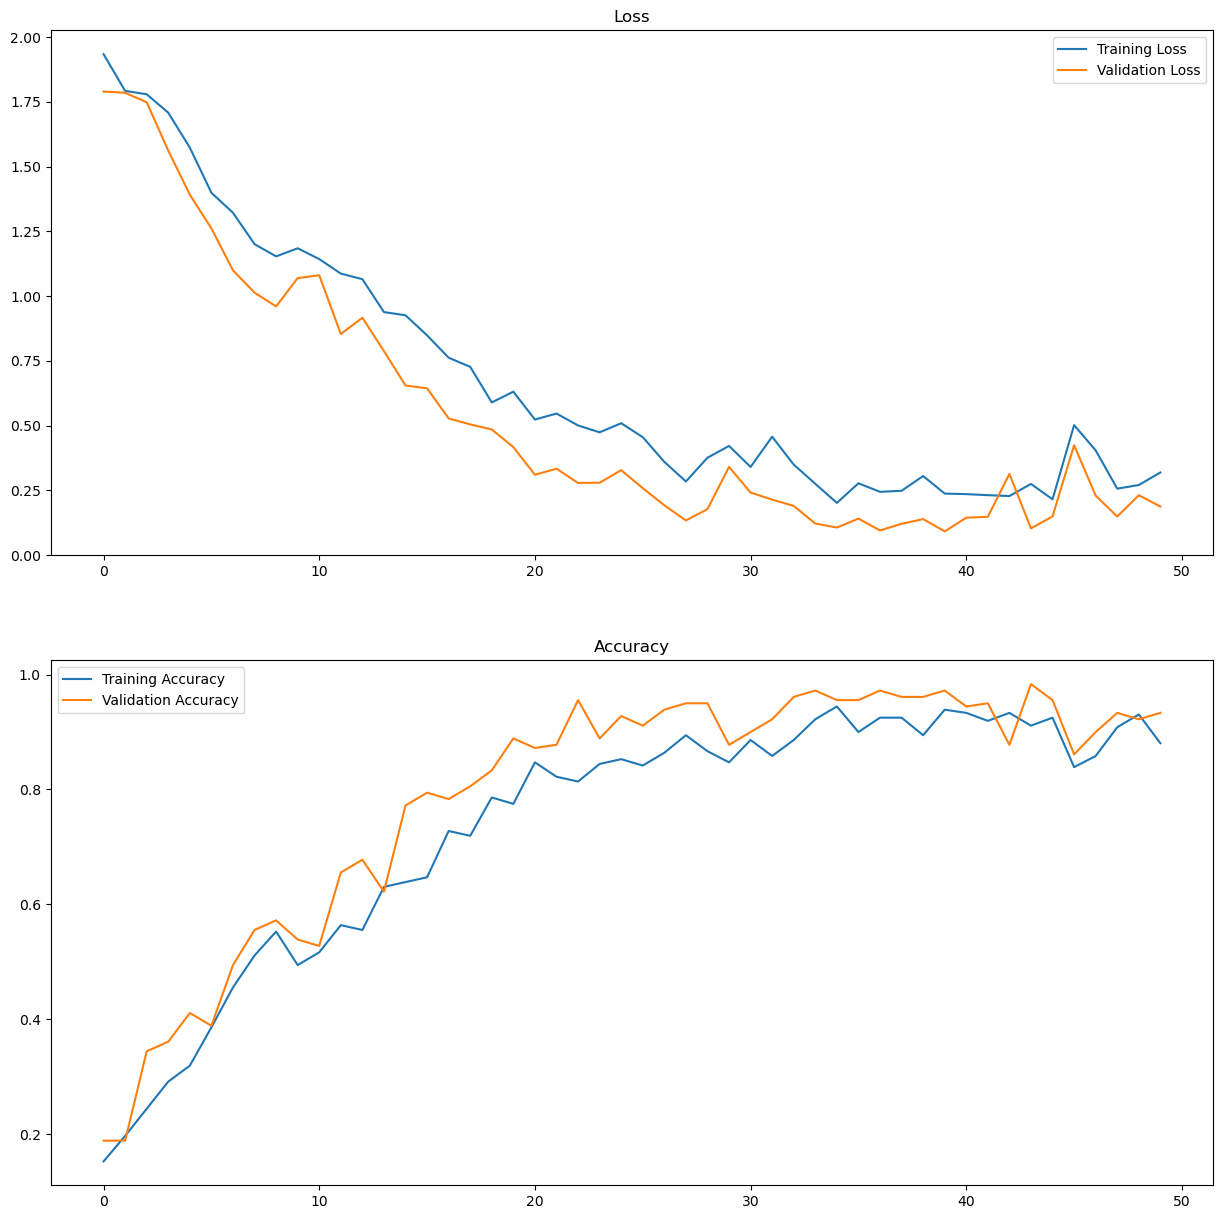

0.9833333492279053

In [12]:
#########################################################################
# Visualise Training & Validation Performance
#########################################################################

# plot validation results
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Training Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["accuracy"], label="Training Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[1].legend()
plt.show()

# get best epoch performance for validation accuracy
max(history.history['val_accuracy'])


In [13]:
#98.3% accuracy
#Augmentation really worked well here

In [21]:
#########################################################################
# Make Predictions On New Data (Test Set)
#########################################################################

# parameters for prediction

model_filename = 'models/fruits_cnn_tuned.h5' #h5 is file format keras will use to save architecture and values of network parameters
#Need these so that network was scanned through images in this size...we need to make sure we pass in images in the same size as we did before
img_height = 128
img_width = 128
labels_list = ['apple', 'avocado', 'banana', 'kiwi', 'lemon', 'orange'] #Written in alphabetical order in the same way they are in the directory

# load model

model = load_model(model_filename)

# import image & apply pre-processing

filepath = 'data/test/banana/banana_0074.jpg'

image = load_img(filepath, target_size = (img_width, img_height))
image = img_to_array(image)
image = np.expand_dims(image, axis = 0) #axis=0 to tell numpy where to add...it will add at start of array
#image.shape #Now there is one dimension added here, keras needs to know how many arrays, we have 1 array added now at the beginning...a batch of 1
image = image * (1./255) #Normalize pixel values 

# predict class probabilities
class_probs = model.predict(image)

# print class probabilities
print("Shape of class_probs:", class_probs.shape)
print("Class probabilities:", class_probs)

# find the predicted class index
predicted_class = np.argmax(class_probs)
print("Predicted class index:", predicted_class)

# find the predicted label
predicted_label = labels_list[predicted_class]
print("Predicted label:", predicted_label)

# image pre-processing function

def preprocess_image(filepath):
    image = load_img(filepath, target_size = (img_width, img_height))
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    image = image * (1./255) 
    return image

# image prediction function

def make_prediction(image):
    
    class_probs = model.predict(image)
    predicted_class = np.argmax(class_probs)
    predicted_label = labels_list[predicted_class]
    predicted_prob = class_probs[0][predicted_class]
    
    return predicted_label,predicted_prob

#loop through test data
source_dir = "data/test/"
folder_names = ['apple', 'avocado', 'banana', 'kiwi', 'lemon', 'orange']
actual_labels = []
predicted_labels = []
predicted_probabilities = []
filenames = []

for folder in folder_names:
    images = listdir(source_dir + '/' + folder)
    
    for image in images:
        
        processed_image = preprocess_image(source_dir + '/' + folder + '/' + image)
        predicted_label, predicted_probability = make_prediction(processed_image)
        
        actual_labels.append(folder)
        predicted_labels.append(predicted_label)
        predicted_probabilities.append(predicted_probability)
        filenames.append(image)


Shape of class_probs: (1, 6)
Class probabilities: [[4.9360661e-04 1.4590272e-07 9.9450028e-01 1.9293161e-06 5.0032036e-03
  8.6538824e-07]]
Predicted class index: 2
Predicted label: banana


In [22]:
# create dataframe to analyse
predictions_df = pd.DataFrame({"actual_label":actual_labels,
                              "predicted_label":predicted_labels,
                              "predicted_probability":predicted_probabilities,
                              "filename":filenames})

predictions_df["correct"] = np.where(predictions_df["actual_label"] == predictions_df["predicted_label"], 1, 0) #1 for correct, 0 for not correct

predictions_df

,actual_label,predicted_label,predicted_probability,filename,correct
0,apple,apple,1.000000,apple_0004.jpg,1
1,apple,apple,1.000000,apple_0014.jpg,1
2,apple,apple,1.000000,apple_0024.jpg,1
3,apple,apple,0.999979,apple_0034.jpg,1
4,apple,apple,1.000000,apple_0044.jpg,1
5,apple,apple,1.000000,apple_0054.jpg,1
6,apple,apple,1.000000,apple_0064.jpg,1
7,apple,apple,1.000000,apple_0074.jpg,1
8,apple,apple,1.000000,apple_0084.jpg,1
9,apple,banana,0.483976,apple_0094.jpg,0


In [23]:
# overall test set accuracy
test_set_accuracy = predictions_df["correct"].sum() / len(predictions_df)
print(test_set_accuracy)
#98.3%

0.9833333333333333


In [28]:
# confusion matrix raw numbers
confusion_matrix = pd.crosstab(predictions_df["predicted_label"], predictions_df["actual_label"])
confusion_matrix

actual_label,apple,avocado,banana,kiwi,lemon,orange
predicted_label,,,,,,
apple,9,0,0,0,0,0
avocado,0,10,0,0,0,0
banana,1,0,10,0,0,0
kiwi,0,0,0,10,0,0
lemon,0,0,0,0,10,0
orange,0,0,0,0,0,10


In [25]:
#Actual scores are along the top
#Predicted scores are along the left hand side
#For apples, 9/10 were right, for avacados 10/10, for bananas 10/10, for lemons 10/10


In [26]:
#Confusion matrix percentages
confusion_matrix = pd.crosstab(predictions_df["predicted_label"], predictions_df["actual_label"], normalize = 'columns')
confusion_matrix


actual_label,apple,avocado,banana,kiwi,lemon,orange
predicted_label,,,,,,
apple,0.9,0.0,0.0,0.0,0.0,0.0
avocado,0.0,1.0,0.0,0.0,0.0,0.0
banana,0.1,0.0,1.0,0.0,0.0,0.0
kiwi,0.0,0.0,0.0,1.0,0.0,0.0
lemon,0.0,0.0,0.0,0.0,1.0,0.0
orange,0.0,0.0,0.0,0.0,0.0,1.0
